In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import os
os.chdir('/media/shubham/04505A8E505A85F8/Data Science/kaggle/Mercedes')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [5]:
#removing int columns having only one type of value
columns = train.columns[train.dtypes == 'int64']
value_df = train[columns].apply(lambda x: len(np.unique(x))).reset_index()
value_df.columns = ['column name','count']
col_name = value_df.loc[value_df['count'] == 1, 'column name']
col_1 = col_name.tolist()
train.drop(col_1, axis=1, inplace=True)
test.drop(col_1,axis=1,inplace=True)

In [6]:
# label encoding
for f in ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
    label = preprocessing.LabelEncoder()
    label.fit(list(train[f].values))
    train[f] = label.transform(list(train[f].values))
    label.fit(list(test[f].values))
    test[f] = label.transform(list(test[f].values))

In [7]:
train.shape

(4209, 366)

In [8]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,32,23,17,0,3,24,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,32,21,19,4,3,28,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,3,27,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,20,21,34,5,3,27,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,3,12,3,13,...,0,0,0,0,0,0,0,0,0,0


In [11]:
### using tpot library
tpot_train = train.drop('ID',axis=1)
tpot_test = test.drop('ID',axis=1)
target = tpot_train['y']
tpot_train.drop('y',axis=1,inplace=True)

In [12]:
from tpot import TPOTRegressor
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tpot_train, target,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=15, population_size=200, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_boston_pipeline.py')


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=3, DecisionTreeRegressor__min_samples_leaf=18, DecisionTreeRegressor__min_samples_split=5)
80.4315659865


In [21]:
tpot_pred = tpot.predict(tpot_test)

In [22]:
#solution file
solution = pd.DataFrame(test['ID'])
solution['y'] = tpot_pred
solution.to_csv('tpot.csv',index=False)

In [7]:
## random split
training = train.drop(['y','ID'], axis=1)
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(training,train['y'])

In [8]:
## random forest model
rf = RandomForestRegressor(n_estimators=300, max_depth=12, min_samples_leaf=4, max_features=0.2, random_state=1)
rf.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=0.2, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [9]:
# checking score on cross val
cross_val_score(rf,test_x,test_y, cv=10)

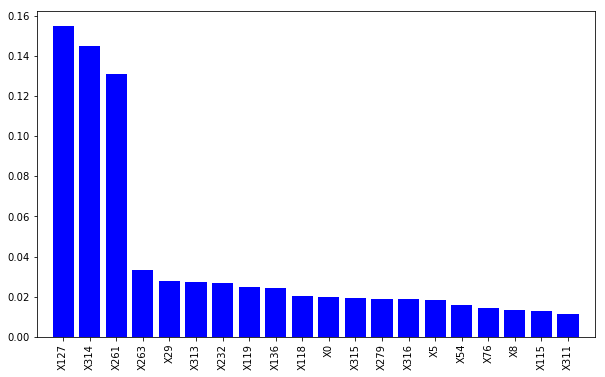

In [9]:
## plotting importance
features = train_x.columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [9]:
## baseline model prediction
rf.fit(train[features[indices]],train['y'])
pred = rf.predict(test[features[indices]])

In [127]:
#solution file
solution = pd.DataFrame(test['ID'])
solution['y'] = pred
solution.to_csv('solution.csv',index=False)

In [10]:
##### using pca then random forest ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
pca_train = scale((train.drop(['y'],axis=1)).values)
pca_test = scale(test.values)
pca = PCA(n_components=364)
pca.fit(pca_train)

/home/shubham/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


PCA(copy=True, iterated_power='auto', n_components=364, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

var1 at 240 = 99.96


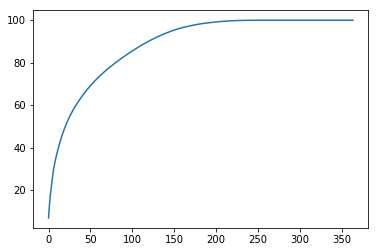

In [11]:
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(var, decimals=4)*100)
plt.plot(var1)
print ("var1 at 240 = %2.2f" % var1[240])

In [12]:
## taking only 10 components
pca = PCA(n_components=10)
#pca.fit(pca_train)
pca_training = pca.fit_transform(pca_train)
pca_testing = pca.transform(pca_test)

In [13]:
training = pd.DataFrame(data = pca_training[0:,0:])
testing = pd.DataFrame(data = pca_testing[0:,0:])

In [14]:
training['ID'] = train['ID']
pca_train1 = pd.merge(train,training, on = 'ID')
testing['ID'] = test['ID']
pca_test1 = pd.merge(test,testing,on="ID")

In [43]:
## random forest using pca (cv)
train_x, test_x, train_y, test_y = train_test_split(pca_train1.drop(['ID'],axis=1),pca_train1['y'])
rf.fit(train_x,train_y)
cross_val_score(rf, test_x,test_y, cv=10)

array([ 0.91885718,  0.83273995,  0.88617924,  0.92114079,  0.82652669,
        0.95519271,  0.89459374,  0.91127776,  0.95948131,  0.8943673 ])

In [15]:
rf.fit(pca_train1.drop(['ID','y'],axis=1), pca_train1['y'])
pred = rf.predict(pca_test1.drop(['ID'],axis=1))

In [48]:
## parameter tuning of random forest
for n in [50,100,200,300]:
    for d in [8,10,12,14]:
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, min_samples_leaf=4,
                                   max_features=0.2, random_state=1)
        rf.fit(train_x,train_y)
        print (n,d,cross_val_score(rf, test_x,test_y, cv=5))

50 8 [ 0.82744098  0.89061304  0.86165983  0.85674195  0.90269995]
50 10 [ 0.84681272  0.90974642  0.87043126  0.89597986  0.92310994]
50 12 [ 0.8594123   0.90374139  0.88183804  0.89256225  0.93419602]
50 14 [ 0.86101558  0.89265089  0.87723422  0.89946123  0.92919071]
100 8 [ 0.84076281  0.89517183  0.86388142  0.88552152  0.91269018]
100 10 [ 0.85746429  0.902351    0.87465713  0.90846862  0.93125158]
100 12 [ 0.8775689   0.90311873  0.87748847  0.90204181  0.93814973]
100 14 [ 0.86818012  0.90296705  0.87626515  0.90750677  0.9286299 ]
200 8 [ 0.86173196  0.89128577  0.86037201  0.89174479  0.91786136]
200 10 [ 0.86965     0.90153563  0.86933759  0.90809187  0.92813701]
200 12 [ 0.88270027  0.9053269   0.87286385  0.90304805  0.93848754]
200 14 [ 0.87233654  0.90418881  0.87211504  0.90826926  0.93054869]
300 8 [ 0.86316109  0.89152365  0.86497267  0.89513931  0.9193982 ]
300 10 [ 0.87388586  0.90419492  0.87425049  0.90929283  0.92691867]
300 12 [ 0.88119333  0.9041202   0.8772117

In [16]:
## adding ica parameters
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

In [17]:
## adding it to train and test
ica2_results_train = pd.DataFrame(data = ica2_results_train[0:,0:])
ica2_results_test = pd.DataFrame(data = ica2_results_test[0:,0:])
ica2_results_train['ID'] = train['ID']
final_train = pd.merge(pca_train1,ica2_results_train, on='ID')
ica2_results_test['ID'] = test['ID']
final_test = pd.merge(pca_test1,ica2_results_test, on ='ID')

In [26]:
# random forest model
rf = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=4,
                                   max_features=0.2, random_state=1)
rf.fit(final_train.drop('y',axis=1),final_train['y'])
rf_pred = rf.predict(final_test)

In [57]:
rf_tpred = rf.predict(final_train.drop('y',axis=1))

In [39]:
#solution file
solution = pd.DataFrame(test['ID'])
solution['y'] = rf_pred
solution.to_csv('rf_pred.csv',index=False)

In [27]:
r2_score(final_train['y'],rf.predict(final_train.drop('y',axis=1)))

0.67632370117675256

In [18]:
final_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0,130.81,32,23,17,0,3,24,9,14,...,-0.012076,0.055706,-0.003247,-0.007201,0.020324,-0.014586,-0.002302,-0.004645,-0.014563,-0.033306
1,6,88.53,32,21,19,4,3,28,11,14,...,-0.003178,0.064108,-0.008808,-0.006876,0.020453,-0.025289,-0.000173,-0.006105,-0.007012,0.000733
2,7,76.26,20,24,34,2,3,27,9,23,...,0.002669,0.061362,-0.007540,0.006749,0.022856,-0.015241,0.015132,-0.023838,-0.026481,-0.011567
3,9,80.62,20,21,34,5,3,27,11,4,...,0.000392,0.062544,-0.006894,0.007960,0.019111,-0.025509,0.005424,0.016447,-0.027331,0.014849
4,13,78.02,20,23,34,5,3,12,3,13,...,-0.003333,0.030945,0.012991,0.007805,0.020816,0.018466,0.013598,-0.001895,-0.032349,0.016118


In [101]:
import xgboost as xgb
#base_score= np.mean(training['segment'])
xgb_para = {
    
    'eta':0.05,
    'max_depth':6,
    'subsample':0.75,
    'objective':'reg:linear',
    'colsample_bytree':0.8,
    'min_child_weight':1,
    'eval_metric':'rmse',
    #'base-score': base_score
}

In [102]:
#Dmatrix
dtrain = xgb.DMatrix(final_train.drop(['y'], axis=1), final_train['y'])
dtest = xgb.DMatrix(final_test)

In [104]:
#xgboost cv
cv_result = xgb.cv(xgb_para,
                   dtrain,
                   num_boost_round=200,
                   early_stopping_rounds=50,
                   verbose_eval=50,
                   show_stdv=False)
num_boost_rounds = len(cv_result)
print (num_boost_rounds)

model = xgb.train(dict(xgb_para), dtrain,num_boost_round=num_boost_rounds)

[0]	train-rmse:95.9717	test-rmse:95.9699
[50]	train-rmse:10.6123	test-rmse:11.2375
[100]	train-rmse:6.35328	test-rmse:8.46569
101


In [105]:
from sklearn.metrics import r2_score
print (r2_score(dtrain.get_label(),model.predict(dtrain)))

0.714930167126


In [106]:
# making pred
xgb_pred = model.predict(dtest)
xgb_tpred = model.predict(dtrain)
#solution file
solution = pd.DataFrame(test['ID'])
solution['y'] = pred
solution.to_csv('xgb_pred.csv',index=False)

In [107]:
light_pred = pd.read_csv('solution.csv')

In [42]:
## ensembling by taking avg of xgb rf and light
lgbm = light_pred['y']

In [49]:
final_pred = (0.3*lgbm + 0.5*xgb_pred + 0.2*rf_pred)
##solution
solution = pd.DataFrame(test['ID'])
solution['y'] = final_pred
solution.to_csv('solution.csv',index=False)

In [93]:
## linear regression
from sklearn.linear_model import Lasso
lreg = Lasso(alpha=0.1,normalize=False)
lreg.fit(final_train.drop('y',axis=1),final_train['y'])
lreg_pred= lreg.predict(final_test)

In [94]:
r2_score(final_train['y'],lreg.predict(final_train.drop('y',axis=1)))

0.54527527550618737

In [95]:
lreg_tpred = lreg.predict(final_train.drop('y',axis=1))

In [98]:
r2_score(final_train['y'], (0.1*lreg_tpred + 0.2*rf_tpred + 0.7*xgb_tpred))

0.69807402523725703

In [108]:
ens_pred= pd.read_csv('subXgb_Stack_Stack_No_ID.csv')

In [109]:
final_pred = (xgb_pred + ens_pred['y'])/2
##solution
solution = pd.DataFrame(test['ID'])
solution['y'] = final_pred
solution.to_csv('solution.csv',index=False)